# BitFEAR: Time Series Analysis

Experimental analysis and learning using:

* Tweets containing #bitcoin, with Vader sentiment scores
* Tweet volume for #bitcoin
* Google Trends data
* Deribit Bitcoin Options orderbook data
* Bitcoin price data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"] = (16, 10)

### Getting tweets from Google Cloud Storage

In [3]:
from google.cloud import firestore
import json

In [4]:
db = firestore.Client()
tweets_ref = db.collection('tweet_data_#bitcoin')

tweets = list()
tweet_docs = list()
#for doc in tweets_ref.stream():
#    tweets.append(doc.to_dict())
    
def count_collection(coll_ref, count, cursor=None):

    if cursor is not None:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").start_after(cursor).stream()]
    else:
        docs = [snapshot for snapshot
                in coll_ref.limit(1000).order_by("__name__").stream()]

    count = count + len(docs)
    tweet_docs.append(docs)

    if len(docs) == 1000:
        return count_collection(coll_ref, count, docs[999].reference.get())
    else:
        print(count)

In [5]:
# ONLY RUN THIS CELL TO RETREIVE TWEETS FROM THE BEGINNING (EXPENSIVE!)

count_collection(tweets_ref, 0)
last_tweet = tweet_docs[-1][-1].reference.get()

262197


In [222]:
# Get tweets since last retreival

count_collection(tweets_ref, 0, last_tweet)
last_tweet = tweet_docs[-1][-1].reference.get()

6728


In [223]:
tweets += [item.to_dict() for sublist in tweet_docs for item in sublist]

In [230]:
tweets_df = pd.DataFrame(tweets)
tweets_df['compound'] = pd.json_normalize(tweets_df['sentiment_scores'])['compound']
tweets_df = tweets_df.filter(['created', 'tweet_id', 'user_id', 'compound'])

In [231]:
tweets_df = tweets_df.drop_duplicates()
tweets_df

,created,tweet_id,user_id,compound
0,2020-03-09 19:43:06+00:00,1237101627925987329,116270443,0.0000
1,2020-03-09 19:43:20+00:00,1237101685757087744,2372242398,0.4926
2,2020-03-09 19:43:26+00:00,1237101710935392256,1075804135524585473,0.4926
3,2020-03-09 19:43:30+00:00,1237101728488718336,877210351301001216,0.0000
4,2020-03-09 19:43:32+00:00,1237101736650661888,1153377427034259457,0.4019
...,...,...,...,...
793417,2020-04-21 16:03:32+00:00,1252629048385327106,1194432385,0.0000
793418,2020-04-21 16:03:35+00:00,1252629059185659909,1271261790,0.0000
793419,2020-04-21 16:03:39+00:00,1252629077317607425,1245379626257481728,0.5994
793420,2020-04-21 16:03:49+00:00,1252629121563275265,727216980449587200,0.0000


### Calculate tweet volume

In [232]:
tweets_time_df = tweets_df.set_index('created').filter(['tweet_id', 'compound'])
tweets_time_df

,tweet_id,compound
created,,
2020-03-09 19:43:06+00:00,1237101627925987329,0.0000
2020-03-09 19:43:20+00:00,1237101685757087744,0.4926
2020-03-09 19:43:26+00:00,1237101710935392256,0.4926
2020-03-09 19:43:30+00:00,1237101728488718336,0.0000
2020-03-09 19:43:32+00:00,1237101736650661888,0.4019
...,...,...
2020-04-21 16:03:32+00:00,1252629048385327106,0.0000
2020-04-21 16:03:35+00:00,1252629059185659909,0.0000
2020-04-21 16:03:39+00:00,1252629077317607425,0.5994


In [276]:
tweet_grouped = tweets_time_df.groupby(pd.Grouper(freq='5Min'))
tweet_volume = tweet_grouped.count()
tweet_volume

,tweet_id,compound
created,,
2020-03-09 19:40:00+00:00,13,13
2020-03-09 19:45:00+00:00,29,29
2020-03-09 19:50:00+00:00,30,30
2020-03-09 19:55:00+00:00,40,40
2020-03-09 20:00:00+00:00,40,40
...,...,...
2020-04-21 15:40:00+00:00,30,30
2020-04-21 15:45:00+00:00,30,30
2020-04-21 15:50:00+00:00,23,23


Text(0.5, 1.0, '#bitcoin Tweets per 5 min')

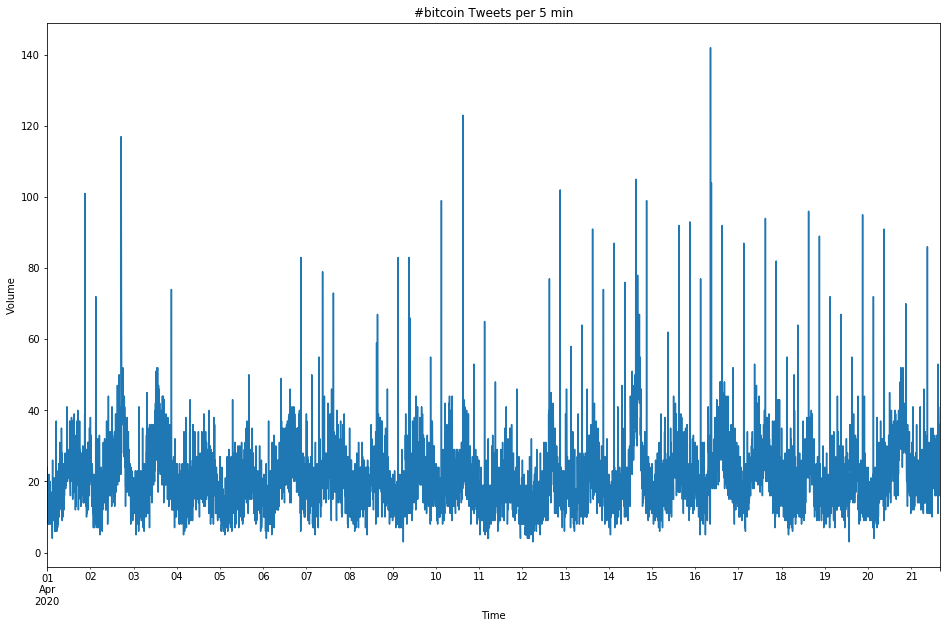

In [277]:
plot_start_date = '2020-04-01'

ax = tweet_volume['tweet_id'].loc[plot_start_date:].plot()
ax.set_xlabel('Time')
ax.set_ylabel('Volume')
ax.set_title('#bitcoin Tweets per 5 min')

Investigate the spikes:

In [278]:
tweet_volume.sort_values(by='tweet_id')

,tweet_id,compound
created,,
2020-03-10 21:20:00+00:00,0,0
2020-03-11 00:05:00+00:00,0,0
2020-03-11 00:10:00+00:00,0,0
2020-03-11 00:15:00+00:00,0,0
2020-03-11 00:20:00+00:00,0,0
...,...,...
2020-03-12 10:45:00+00:00,134,134
2020-03-13 00:00:00+00:00,142,142
2020-04-16 08:30:00+00:00,142,142


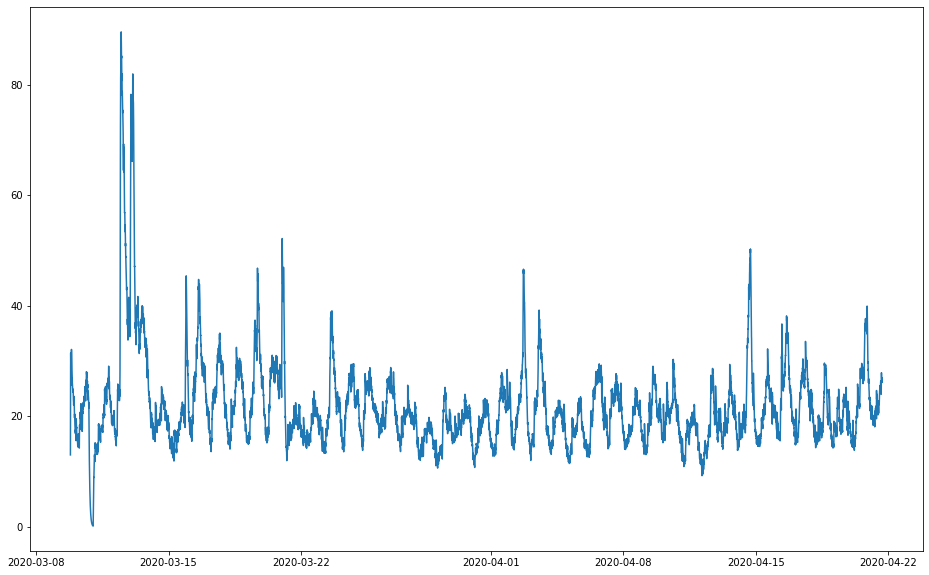

In [279]:
tweet_volume['smooth'] = tweet_volume['tweet_id'].ewm(12).mean()
plt.plot(tweet_volume['smooth'])

### Tweet sentiment time series

In [280]:
sentiment_time = tweet_grouped.mean()
sentiment_time

,compound
created,
2020-03-09 19:40:00+00:00,0.261085
2020-03-09 19:45:00+00:00,0.194479
2020-03-09 19:50:00+00:00,0.176573
2020-03-09 19:55:00+00:00,0.081617
2020-03-09 20:00:00+00:00,0.050008
...,...
2020-04-21 15:40:00+00:00,0.135067
2020-04-21 15:45:00+00:00,0.192487
2020-04-21 15:50:00+00:00,0.209696


Text(0, 0.5, 'Mean Sentiment Rating')

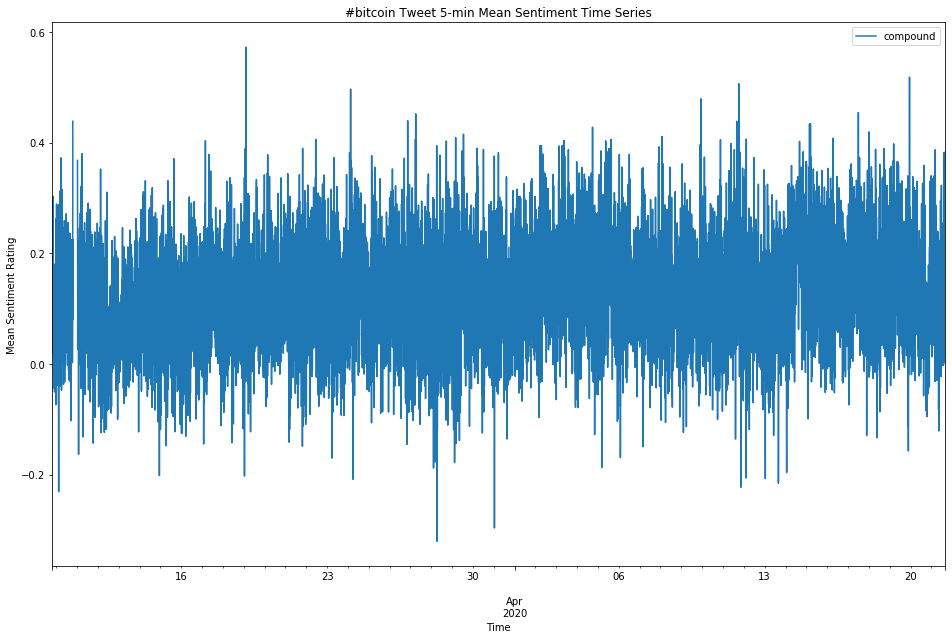

In [281]:
sentiment_time.plot()
plt.title('#bitcoin Tweet 5-min Mean Sentiment Time Series')
plt.xlabel('Time')
plt.ylabel('Mean Sentiment Rating')

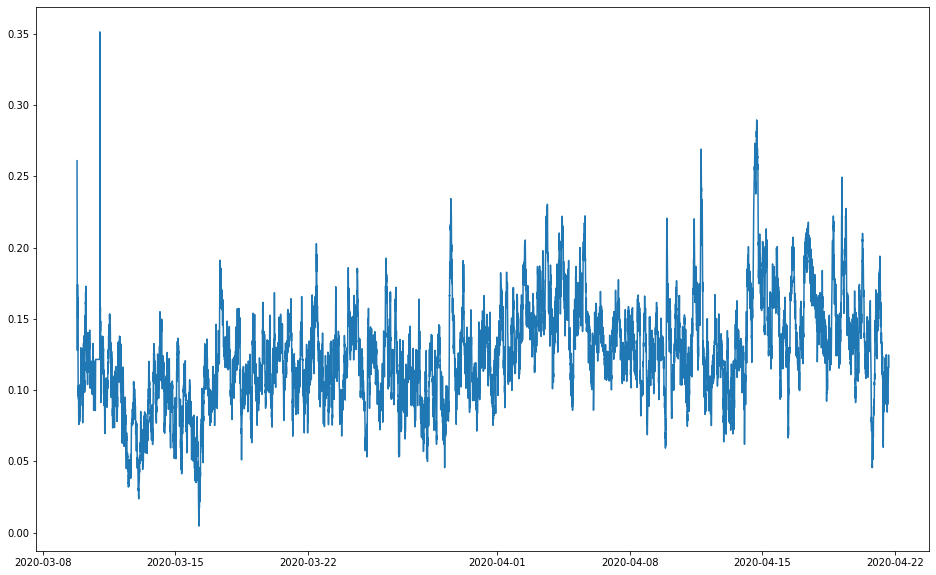

In [312]:
sentiment_time['smooth'] = sentiment_time['compound'].ewm(12).mean()
plt.plot(sentiment_time['smooth'])

### Google Trends Data

In [237]:
from pytrends.request import TrendReq

In [238]:
focus_words = ['bitcoin']

pygt = TrendReq()
pygt.build_payload(kw_list=focus_words)

interest_over_time_df = pygt.interest_over_time()
del interest_over_time_df['isPartial']
interest_over_time_df

,bitcoin
date,
2015-04-26,2
2015-05-03,2
2015-05-10,2
2015-05-17,2
2015-05-24,2
...,...
2020-03-22,15
2020-03-29,13
2020-04-05,13


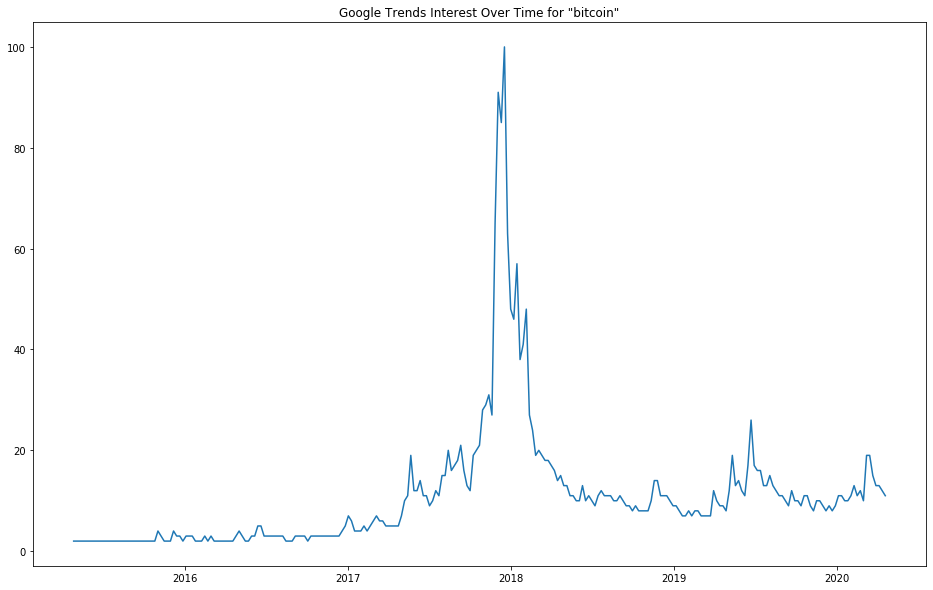

In [239]:
plot = plt.plot(interest_over_time_df)
plt.title('Google Trends Interest Over Time for "bitcoin"')
plt.show()

In [240]:
historical_hourly_interest_df = pygt.get_historical_interest(focus_words, year_start=2020, month_start=4, day_start=17, hour_start=0, year_end=2020, month_end=4, day_end=21, hour_end=17, cat=0, geo='', gprop='').drop('isPartial', axis=1)
historical_hourly_interest_df

The request failed: Google returned a response with code 400.


,bitcoin
date,
2020-04-17 00:00:00,82
2020-04-17 01:00:00,78
2020-04-17 02:00:00,78
2020-04-17 03:00:00,80
2020-04-17 04:00:00,81
...,...
2020-04-21 12:00:00,72
2020-04-21 13:00:00,72
2020-04-21 14:00:00,72


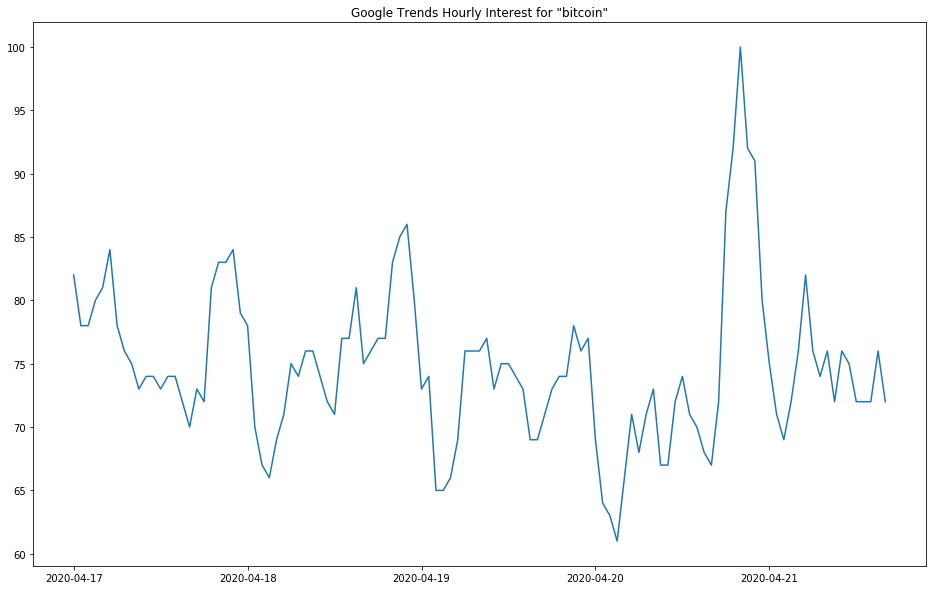

In [241]:
plot = plt.plot(historical_hourly_interest_df)
plt.title('Google Trends Hourly Interest for "bitcoin"')
plt.show()

Some issues with this data.

Upsample with linear interpolation to five minute intervals to match other data series.

In [242]:
gtrend_5min_df = pd.DataFrame(historical_hourly_interest_df.bitcoin.resample('5min').interpolate(method='linear'))
gtrend_5min_df.index = gtrend_5min_df.index.tz_localize('UTC')
gtrend_5min_df

,bitcoin
date,
2020-04-17 00:00:00+00:00,82.000000
2020-04-17 00:05:00+00:00,81.666667
2020-04-17 00:10:00+00:00,81.333333
2020-04-17 00:15:00+00:00,81.000000
2020-04-17 00:20:00+00:00,80.666667
...,...
2020-04-21 15:40:00+00:00,73.333333
2020-04-21 15:45:00+00:00,73.000000
2020-04-21 15:50:00+00:00,72.666667


### Bitcoin price index data

In [243]:
import requests
from io import StringIO

In [244]:
btc_index_dbit_data = requests.get('https://www.deribit.com/static/csv/2020-04_btc_usd_price_index.csv').content.decode()

In [245]:
btc_index_dbit_df = pd.read_csv(StringIO(btc_index_dbit_data), skiprows=1)
btc_index_dbit_df['Date and Time'] = pd.to_datetime(btc_index_dbit_df['Date and Time'], format='%Y-%m-%d %H:%M:%S')
btc_index_dbit_df = btc_index_dbit_df.set_index('Date and Time').tz_localize('UTC', level=0)
btc_index_dbit_df

,Price
Date and Time,
2020-04-01 00:00:00+00:00,6423.38
2020-04-01 00:00:01+00:00,6423.79
2020-04-01 00:00:02+00:00,6423.72
2020-04-01 00:00:03+00:00,6423.88
2020-04-01 00:00:04+00:00,6424.28
...,...
2020-04-21 16:11:33+00:00,6848.39
2020-04-21 16:11:34+00:00,6848.38
2020-04-21 16:11:35+00:00,6848.33


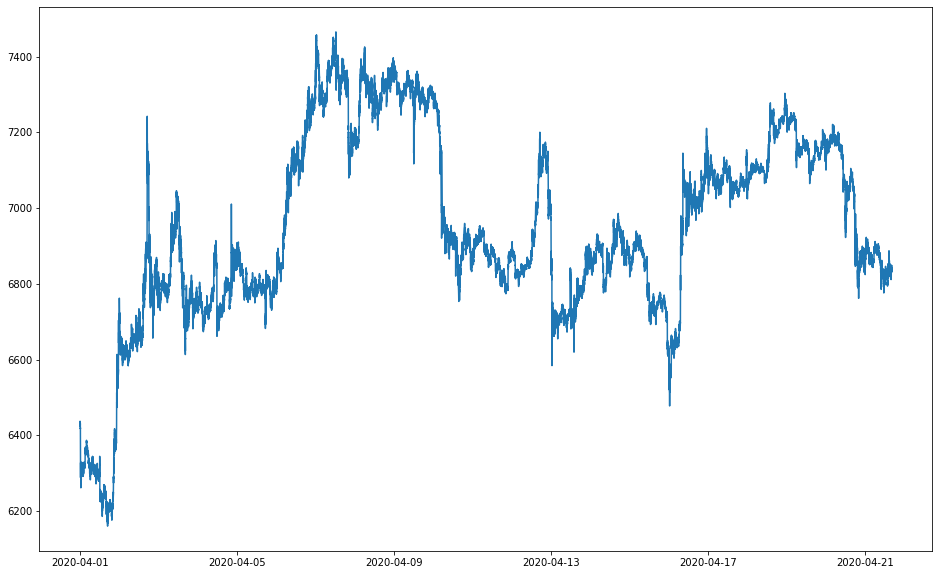

In [246]:
plt.plot(btc_index_dbit_df)

### Volatility index data

In [247]:
indices_df = pd.read_csv('/home/fp361/bitfear/vix-implementation/volatility_data.csv')
indices_df['timestamp'] = pd.to_datetime(indices_df['timestamp'])
indices_df = indices_df.set_index('timestamp').tz_localize('UTC', level=0)
indices_df

,vxbt,gvxbt,avxbt
timestamp,,,
2020-04-17 08:35:00+00:00,0.245807,4.521009,0.000646
2020-04-17 08:40:00+00:00,0.245478,4.541242,0.000649
2020-04-17 08:45:00+00:00,0.246372,4.517866,0.000645
2020-04-17 08:50:00+00:00,0.244503,4.556650,0.000651
2020-04-17 08:55:00+00:00,0.242043,4.555144,0.000651
...,...,...,...
2020-04-21 15:59:00+00:00,0.248443,4.696702,0.000696
2020-04-21 16:00:00+00:00,0.248256,4.692784,0.000695
2020-04-21 16:01:00+00:00,0.247760,4.696981,0.000696


***

## Regression Models

### Data Cleaning

Select a common time range where each series has clean data available:

In [313]:
start_date = max([df.index[0] for df in [btc_index_dbit_df, sentiment_time, tweet_volume, indices_df, gtrend_5min_df]])
end_date = min([df.index[-1] for df in [btc_index_dbit_df, sentiment_time, tweet_volume, indices_df, gtrend_5min_df]])

print(f'Start: {start_date}')
print(f'End: {end_date}')

series_btc = btc_index_dbit_df.loc[start_date:end_date]
series_sentiment = sentiment_time['smooth'].loc[start_date:end_date]
series_volume = tweet_volume.filter(['smooth']).loc[start_date:end_date]
series_indices = indices_df['vxbt'].loc[start_date:end_date]
series_gtrend = gtrend_5min_df['bitcoin'].loc[start_date:end_date]

Start: 2020-04-17 08:35:00+00:00
End: 2020-04-21 16:00:00+00:00


In [314]:
series_sentiment

created
2020-04-17 08:35:00+00:00    0.196330
2020-04-17 08:40:00+00:00    0.197086
2020-04-17 08:45:00+00:00    0.204792
2020-04-17 08:50:00+00:00    0.208757
2020-04-17 08:55:00+00:00    0.213473
                               ...   
2020-04-21 15:40:00+00:00    0.111275
2020-04-21 15:45:00+00:00    0.117522
2020-04-21 15:50:00+00:00    0.124612
2020-04-21 15:55:00+00:00    0.119451
2020-04-21 16:00:00+00:00    0.116089
Freq: 5T, Name: smooth, Length: 1242, dtype: float64

Plot narrowed down time series:

Text(0.5, 0.98, 'Time Series')

/home/fp361/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


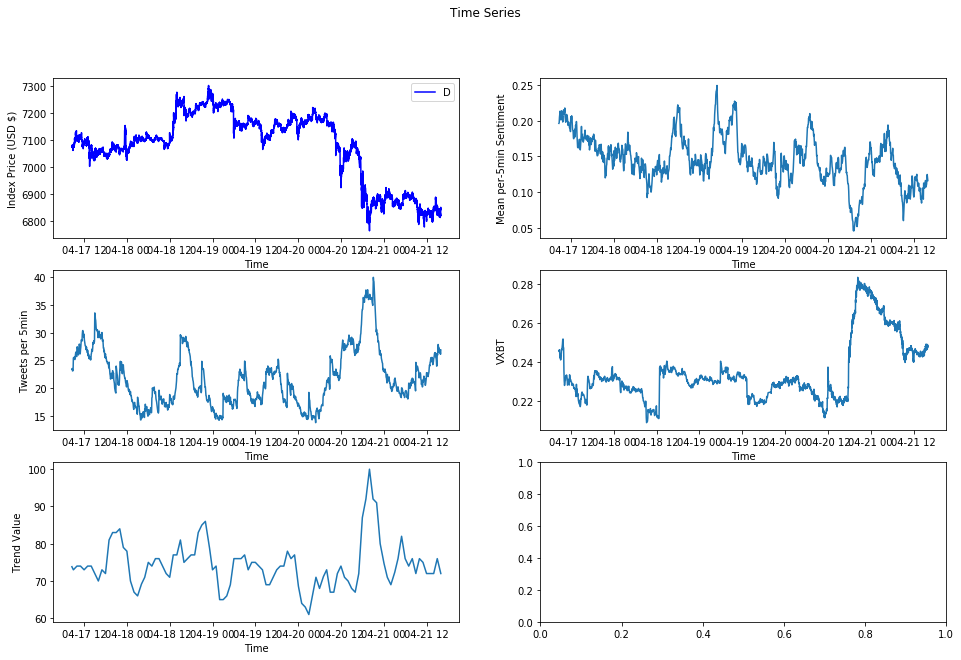

In [315]:
fig, ax =  plt.subplots(3,2)

ax[0][0].plot(series_btc, color='blue')
ax[0][0].legend('Deribit')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Index Price (USD $)')

ax[0][1].plot(series_sentiment)
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('Mean per-5min Sentiment')

ax[1][0].plot(series_volume)
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('Tweets per 5min')

ax[1][1].plot(series_indices)
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('VXBT')

ax[2][0].plot(series_gtrend)
ax[2][0].set_xlabel('Time')
ax[2][0].set_ylabel('Trend Value')

fig.suptitle('Time Series')

Discard Google Trends data for the time being. Need to determine what is causing the strange gaps.

In [316]:
data = pd.DataFrame(series_indices).merge(series_volume, left_index=True, right_index=True).merge(series_sentiment, left_index=True, right_index=True).merge(series_gtrend, left_index=True, right_index=True).merge(series_btc, left_index=True, right_index=True).dropna()
data.columns = ['vxbt', 'tweet_vol', 'sentiment', 'gtrend', 'index']
data['index_next'] = data['index'].shift(-1)
data

,vxbt,tweet_vol,sentiment,gtrend,index,index_next
2020-04-17 08:35:00+00:00,0.245807,23.427471,0.196330,73.833333,7075.78,7075.52
2020-04-17 08:40:00+00:00,0.245478,23.548435,0.197086,73.666667,7075.52,7078.24
2020-04-17 08:45:00+00:00,0.246372,23.121632,0.204792,73.500000,7078.24,7064.75
2020-04-17 08:50:00+00:00,0.244503,23.189199,0.208757,73.333333,7064.75,7067.54
2020-04-17 08:55:00+00:00,0.242043,23.174645,0.213473,73.166667,7067.54,7074.13
...,...,...,...,...,...,...
2020-04-21 15:40:00+00:00,0.246770,26.656316,0.111275,73.333333,6825.57,6818.68
2020-04-21 15:45:00+00:00,0.246556,26.913523,0.117522,73.000000,6818.68,6816.80
2020-04-21 15:50:00+00:00,0.247989,26.612482,0.124612,72.666667,6816.80,6821.39
2020-04-21 15:55:00+00:00,0.248407,26.103830,0.119451,72.333333,6821.39,6840.75


### Linear Regression

In [318]:
X_cols = ['vxbt', 'tweet_vol', 'sentiment', 'gtrend']

X = data.dropna()[X_cols]
Y = data.dropna()['index_next']

In [319]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

linreg = LinearRegression()
linreg = linreg.fit(X_train, Y_train)

In [320]:
print(linreg.intercept_)
print(linreg.coef_)
list(zip([X_cols], linreg.coef_))

7876.007422038989
[-5.05968501e+03 -7.51353862e+00  1.27122690e+03  4.93981181e+00]


[(['vxbt', 'tweet_vol', 'sentiment', 'gtrend'], -5059.685007512886)]

#### Metrics

In [321]:
from sklearn import metrics

Y_pred = np.roll(linreg.predict(X_test), 1)

print('RMSE {}'.format(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))))

RMSE 164.87762973665983


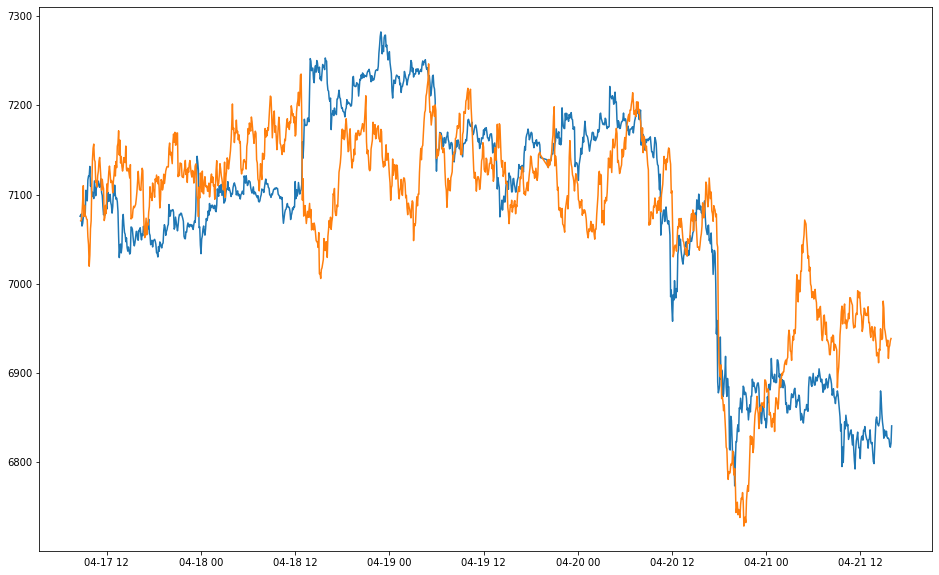

In [322]:
pred = pd.DataFrame(index=X.index)
pred['val'] = linreg.predict(X)
pred['val'] = pred['val'].shift(1)
plt.plot(data['index'])
plt.plot(pred)

### ARIMA

With reference to:

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.ethanrosenthal.com/2018/03/22/time-series-for-scikit-learn-people-part2/

In [198]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [220]:
vals = data['index']

train = vals[:int(0.7*(len(vals)))]
valid = vals[int(0.7*(len(vals))):]

model = pm.auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=4844.160, BIC=4871.194, Time=1.135 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=4850.562, BIC=4859.574, Time=0.026 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=4851.841, BIC=4865.358, Time=0.079 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=4851.811, BIC=4865.329, Time=0.115 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=4848.619, BIC=4853.125, Time=0.018 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=4851.684, BIC=4874.213, Time=0.557 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=4851.423, BIC=4873.952, Time=0.392 seconds
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=4855.399, BIC=4886.939, Time=0.585 seconds
Fit ARIMA: (2, 1, 3)x(0, 0, 0, 0) (constant=True); AIC=4846.141, BIC=4877.682, Time=0.750 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=4853.551, BIC=4871.

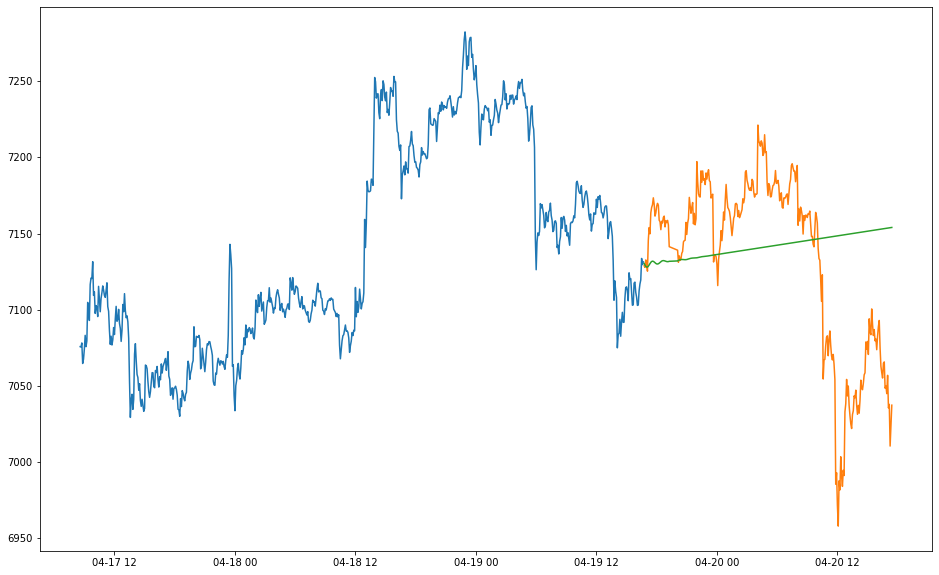

In [221]:
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()